In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import os
import cv2
import math
import h5py
import torch
import PIL
import imghdr
import random
import scipy.io
import colorsys
import argparse
import scipy.misc
%matplotlib inline
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
from functools import reduce
import matplotlib.pyplot as plt
from torchvision import transforms
from tensorflow.keras import layers
from matplotlib.pyplot import imshow
from sklearn.datasets import make_blobs
from tensorflow.keras import backend as K
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFont, ImageDraw, Image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.python.framework.ops import EagerTensor

In [2]:
dataset_path = 'drive/MyDrive/nyu_depth_v2_labeled.mat'
f = h5py.File(dataset_path,'r')
depths = f.get('depths')
depths = np.array(depths) 
depths= np.transpose(depths, (0,2,1))

images = f.get('images')
images = np.array(images)
images= np.transpose(images, (0,3,2,1))

In [3]:
X_train, X_test_, Y_train, Y_test = train_test_split(images, depths, test_size=0.2)
print("X_train" , X_train.shape,"X_test" ,  X_test_.shape, "Y_train" , Y_train.shape, "Y_test" ,  Y_test.shape)

X_train (1159, 480, 640, 3) X_test (290, 480, 640, 3) Y_train (1159, 480, 640) Y_test (290, 480, 640)


In [4]:
del images , depths

In [5]:
Y_train = tf.divide(Y_train , 10) -1
Y_test = tf.divide(Y_test , 10) -1

In [6]:
X_train = tf.cast(X_train, tf.float16)
X_test = tf.cast(X_test_, tf.float16)
X_train = tf.divide(X_train , 255)
X_test = tf.divide(X_test , 255)

In [9]:
def DEPTH_Calc(xmin,ymin,xmax,ymax , pred):
  xmin = math.floor(xmin)
  ymin = math.floor(ymin)
  xmax = math.floor(xmax)
  ymax = math.floor(ymax)
  sum = 0
  num = 1
  for i in range(xmin,xmax +1):
    for j in range(ymin,ymax +1):
      sum += pred[j,i]
  num = (xmax-xmin+1)*(ymax-ymin+1)
  DEPTH = sum/num
  return DEPTH

In [78]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data


def preprocess_image_by_value(image, model_image_size):

    img = Image.fromarray(image, 'RGB')
    resized_image = img.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return img, image_data

def compose(*funcs):

    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def get_colors_for_classes(num_classes):
    """Return list of random colors for number of classes given."""
    # Use previously generated colors if num_classes is the same.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors


def draw_boxes(image, boxes, box_classes, class_names, scores=None, Depth=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """

    font = ImageFont.truetype(
        font='/content/drive/MyDrive/DL_Project/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            depth = Depth[i]
            label = '{} {:.2f}| ({}m)'.format(box_class, score,depth)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)

In [13]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [49]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.9
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.89
        self.loss_metric = tf.keras.metrics.Mean(name="loss")


        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(abs(smoothness_y) )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean( 1  - tf.image.ssim( target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2   )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [50]:
HEIGHT = 480
WIDTH = 640
LR = 0.001
EPOCHS = 30
BATCH_SIZE = 32

In [16]:
optimizer = tf.keras.optimizers.Adam(     learning_rate=LR,  amsgrad=False,)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( patience=3, factor=0.6, min_denta=0.0001)

model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none" )
# Compile the model
model.compile(optimizer, loss=cross_entropy)

history =  model.fit(X_train , np.expand_dims(Y_train, axis=-1), batch_size = 4 ,   validation_split= 0.1 ,  epochs=30 , callbacks = [ reduce_lr] )

Epoch 1/30
261/261 [==============================] - 84s 258ms/step - loss: 0.0676 - val_loss: 0.0513 - lr: 0.0010
Epoch 2/30
261/261 [==============================] - 64s 247ms/step - loss: 0.0369 - val_loss: 0.0391 - lr: 0.0010
Epoch 3/30
261/261 [==============================] - 65s 249ms/step - loss: 0.0401 - val_loss: 0.0407 - lr: 0.0010
Epoch 4/30
261/261 [==============================] - 65s 250ms/step - loss: 0.0357 - val_loss: 0.0356 - lr: 0.0010
Epoch 5/30
261/261 [==============================] - 66s 252ms/step - loss: 0.0316 - val_loss: 0.0342 - lr: 0.0010
Epoch 6/30
261/261 [==============================] - 66s 252ms/step - loss: 0.0314 - val_loss: 0.0339 - lr: 0.0010
Epoch 7/30
261/261 [==============================] - 66s 252ms/step - loss: 0.0310 - val_loss: 0.0328 - lr: 0.0010
Epoch 8/30
261/261 [==============================] - 66s 253ms/step - loss: 0.0307 - val_loss: 0.0322 - lr: 0.0010
Epoch 9/30
261/261 [==============================] - 66s 253ms/step - l

In [18]:
model.save("my_model")
# It can be used to reconstruct the model identically.
reconstructed_model = tf.keras.models.load_model("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
# # Calling `save('my_model')` creates a SavedModel folder `my_model`.
# model.save("depthmodel")
# tensorflow_graph = tf.saved_model.load("depthmodel")
# # x = np.random.uniform(size=(4, 32)).astype(np.float32)
# predicted = tensorflow_graph(x).numpy()

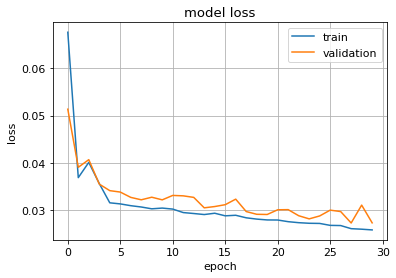

In [141]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

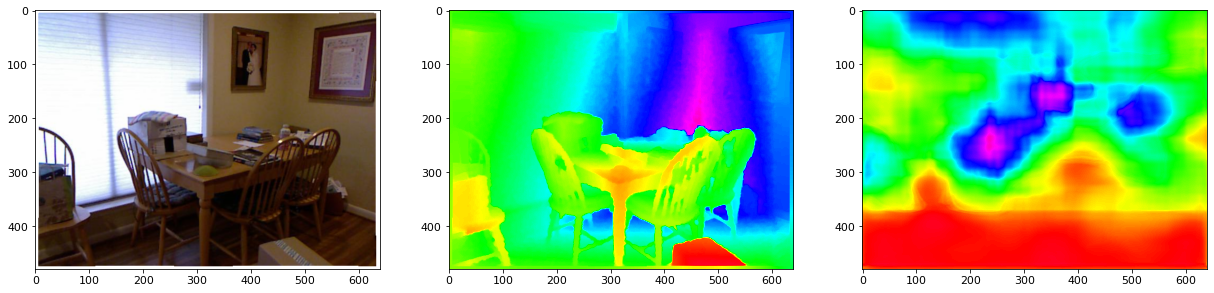

In [142]:
idx = 544
plt.figure(figsize = (21,7))
plt.subplot(1,3,1)
plt.imshow(np.uint8((X_train[idx]*255).numpy()))
plt.subplot(1,3,2)
plt.imshow(Y_train[idx, :, : ],  cmap=plt.cm.gist_rainbow)
plt.subplot(1,3,3)
out1 = model.predict(tf.reshape(X_train[idx], [1, 480 , 640 , 3]))
plt.imshow(out1[0, :, : , 0],  cmap=plt.cm.gist_rainbow)


In [27]:
model_OD = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


In [28]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
from yolov5 import utils
display = utils.notebook_init()  # checks

Setup complete ✅ (2 CPUs, 12.7 GB RAM, 44.5/78.2 GB disk)


xmin        ymin        xmax        ymax  confidence  class   name  \
0  171.362000  132.975464  389.905090  275.857910    0.907987     62     tv   
1    8.225090  252.794281  154.440125  315.603546    0.634381     56  chair   
2  165.148865  270.329193  229.151703  295.235504    0.349179     73   book   
3  438.630066   65.471573  461.529907  106.810852    0.273160     73   book   
4  431.189758  110.538033  464.191284  155.176086    0.264463     73   book   

   depth  
0  2.554  
1  2.014  
2  2.368  
3  3.643  
4  3.592

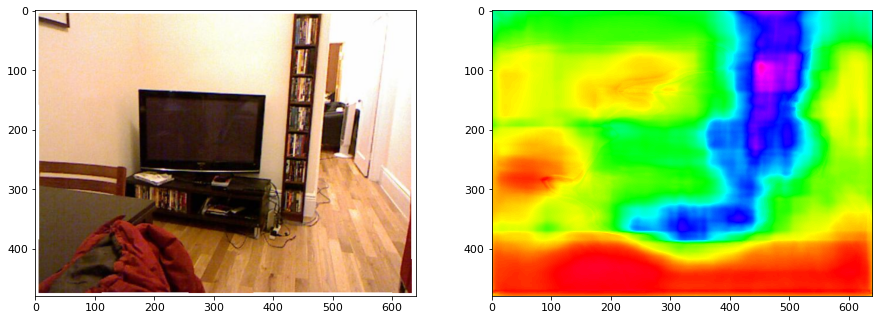

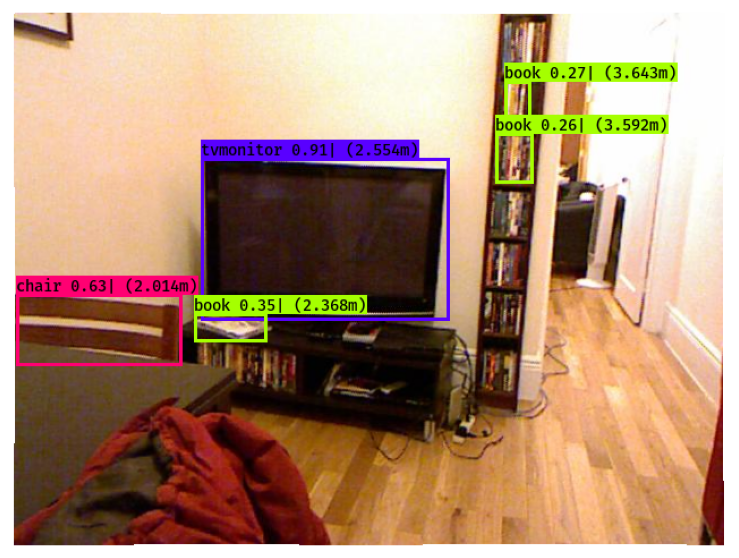

In [120]:
def test_on_testData(idx):
  img_array = X_test_[idx]
  OBJECTS = model_OD((img_array))
  df_OD = OBJECTS.pandas().xyxy[0]
  OBJECTS.save(save_dir='/content/drive/MyDrive/')
  out1 = model.predict( tf.reshape(X_test[idx], [1, 480 , 640 , 3]))
  plt.figure(figsize = (15, 7))
  plt.subplot(1,2,1)
  plt.imshow((img_array))
  plt.subplot(1,2,2)
  plt.imshow(out1[0, :, : , 0],  cmap=plt.cm.gist_rainbow)
  DEPTHS=[]
  for index, row in df_OD.iterrows():
    object_depth = DEPTH_Calc(row['xmin'],row['ymin'],row['xmax'],row['ymax'] , out1[0, :, : , 0])
    object_depth = (object_depth + 1 )*10
    DEPTHS.append(round(object_depth,3))

  df_OD['depth'] = DEPTHS
  df_OD


  image, image_data = preprocess_image_by_value(img_array, model_image_size = (608, 608))

  class_names = read_classes("/content/drive/MyDrive/DL_Project/coco_classes.txt")
  colors = get_colors_for_classes(len(class_names))
  out_boxes = np.zeros((len(df_OD.index),4))
  out_classes=np.zeros((len(df_OD.index)))
  out_scores = np.zeros((len(df_OD.index)))
  for index, row in df_OD.iterrows():
    out_boxes[index,:]=[row['ymin'],row['xmin'],row['ymax'],row['xmax']]
    out_classes[index]=row['class']
    out_scores[index]=row['confidence']

  o2= tf.convert_to_tensor(out_boxes)
  o3= tf.convert_to_tensor(out_classes,dtype=tf.int32)
  o5= tf.convert_to_tensor(out_scores)
  ret_val = draw_boxes(image, o2, o3, class_names, o5, DEPTHS)

  plt.figure(figsize = (20 , 10))
  imshow(image)
  plt.axis ('off')
  return df_OD

idx = 24
test_on_testData(idx) # enter a number between 0 to 290-1 !

xmin        ymin        xmax        ymax  confidence  class  \
0  159.121765  176.622971  348.828918  454.974060    0.870947      0   
1  138.275421  161.879288  241.626251  261.274628    0.836346     77   
2  310.450348  187.890137  376.674286  238.238525    0.716484     62   
3   83.040131  313.855286  133.664642  395.909912    0.712277     24   
4    5.115671  216.438950   40.647873  263.019714    0.501366     63   
5  426.626282  235.772629  520.313416  280.753998    0.321091     26   
6  425.585571  235.142685  521.020203  281.349915    0.320801     24   
7  376.379883  212.211319  386.720947  243.202255    0.281573     39   

         name  depth  
0      person  2.597  
1  teddy bear  3.531  
2          tv  3.597  
3    backpack  2.777  
4      laptop  3.200  
5     handbag  2.760  
6    backpack  2.754  
7      bottle  3.252

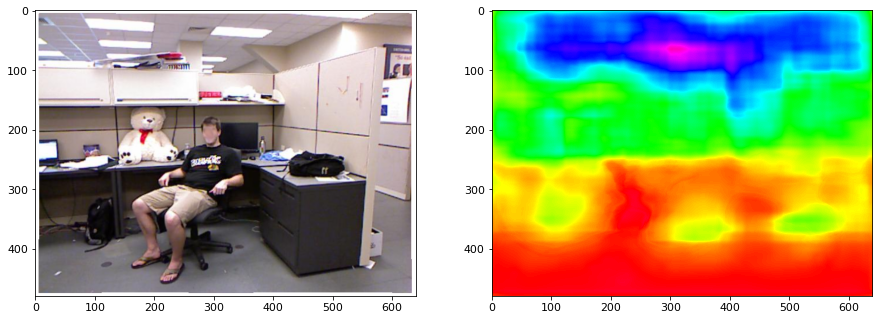

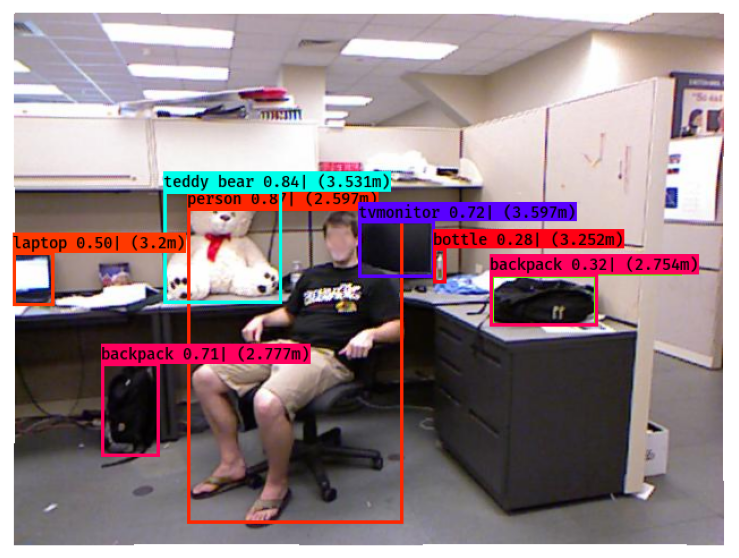

In [121]:
test_on_testData(25)

xmin        ymin        xmax        ymax  confidence  class   name  \
0  303.969604  326.714996  625.531982  473.083649    0.858399     57  couch   
1  381.081604  399.894714  447.256409  427.349670    0.675259     73   book   
2  250.841705  263.704895  334.214020  309.388794    0.339095     62     tv   

   depth  
0  2.112  
1  1.905  
2  3.264

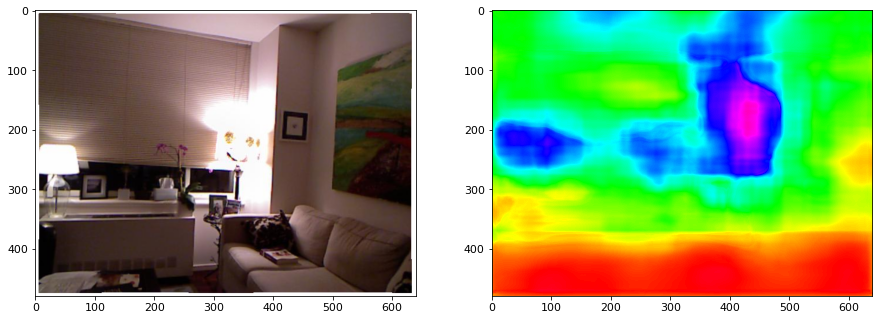

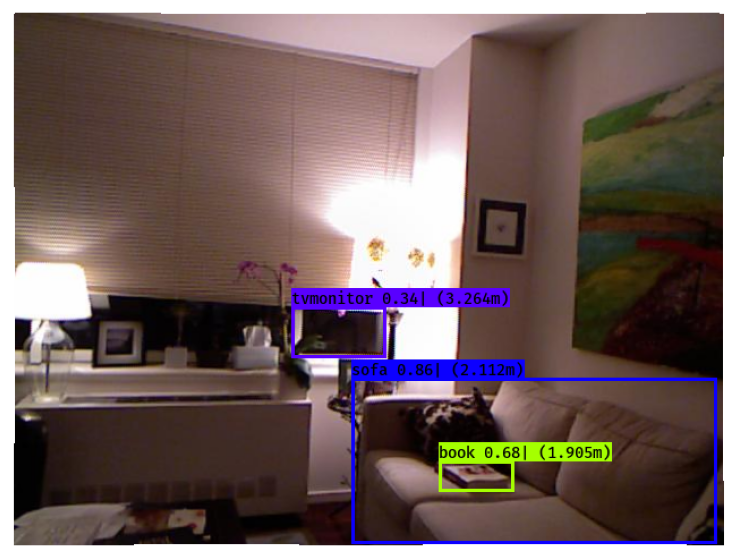

In [124]:
test_on_testData(28)

xmin        ymin        xmax        ymax  confidence  class  \
0  171.551483  353.685516  290.972992  472.457733    0.764213     56   
1  530.709106  311.592804  616.722290  473.562714    0.742662     56   
2  421.929413  354.308319  502.387726  471.687164    0.531410     75   
3   87.007935  212.648712  124.676529  382.782379    0.489205     69   
4  368.987183  210.065125  504.421753  462.454773    0.274445     58   
5  294.044098  297.167755  364.146698  384.386688    0.262173     56   

           name  depth  
0         chair  1.943  
1         chair  2.015  
2          vase  2.074  
3          oven  3.038  
4  potted plant  2.595  
5         chair  2.972

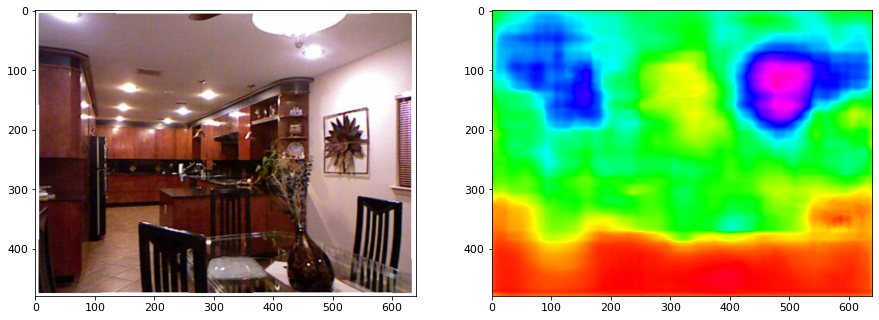

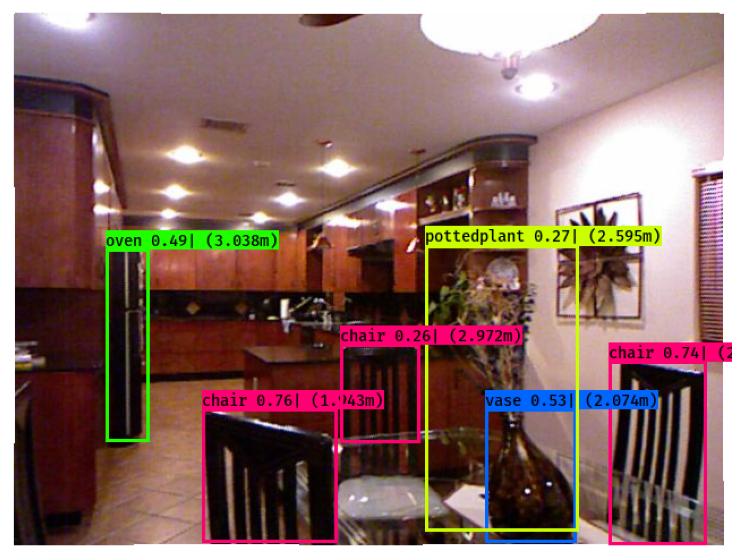

In [134]:
test_on_testData(37)

In [119]:
model.evaluate(X_test ,  np.expand_dims(Y_test, axis=-1))

10/10 [==============================] - 13s 607ms/step - loss: 0.0250


0.024965815246105194